In [1]:
from VIPurPCAvsMC import *
import jax
from jax import jacrev, vmap

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from utils import *
import seaborn as sns
import time

import matplotlib.pyplot as plt
from matplotlib import rcParams

cm = 1 / 2.54
plt.rc('font', size=8)
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)
plt.rc('axes', labelsize=8)
rcParams['font.family'] = "sans-serif"
rcParams['font.sans-serif'] = "Helvetica"

import jax.numpy as np


In [2]:
def cvp(jvp_fun, vjp_fun, X_flat, X_unflattener, C, n, p, p_keep, i):
    v1 = np.ravel(jax.nn.one_hot(np.array([i]), min(n, p_keep)*p))
    v2 = vjp_fun(v1)[0]
    v3 = np.dot(C, v2)
    v4 = jvp_fun(v3)
    return v4

def load_mice_dataset():
    data = np.load('../data/mice/mice_data.npy')
    y = np.load('../data/mice/labels.npy')
    data_reshape = vmap(lambda x: np.ravel(x.reshape((77, 73)), 'C'))(np.transpose(data))
    data = np.transpose(data_reshape)
    print(data.shape)
    cov_Y = np.cov(data)
    mean = np.mean(data, axis=1)
    Y = np.transpose(np.reshape(mean, (77, 73), 'C'))
    return Y, cov_Y, y

In [3]:
X, C_in, y = load_mice_dataset()
X = np.array(X)
n, p = X.shape
X = X - np.mean(X, axis=0)
p_keep=2
X_flat, X_unflattener = flatten_util.ravel_pytree(X)

(5621, 15)


<AxesSubplot:>

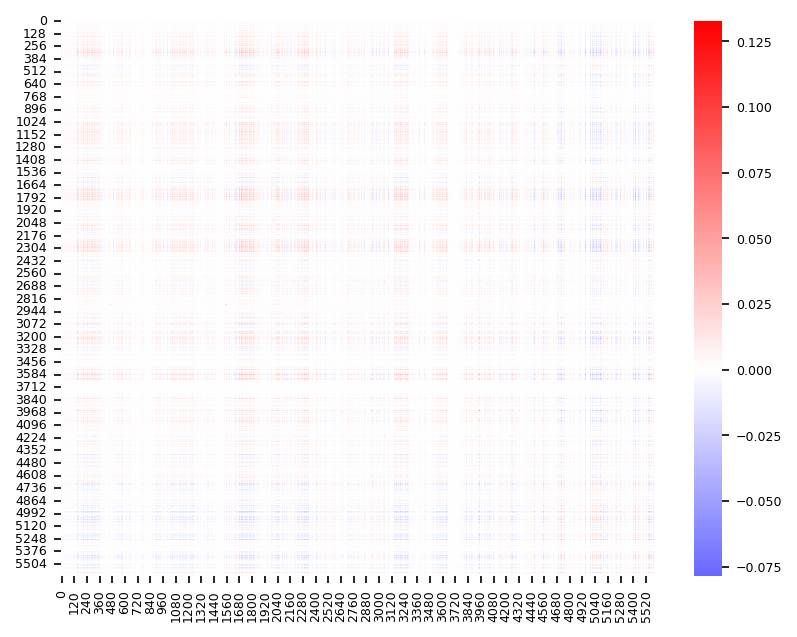

In [4]:
plot_heatmap(C_in)

In [5]:
le = LabelEncoder()
y = le.fit_transform(y)

In [16]:
n_iter=100
V = pca(X_flat, X_unflattener, p_keep)
f = lambda X: pca(X, X_unflattener, p_keep)
_, f_vjp = vjp(f, X_flat)
_, f_jvp = jax.linearize(f, X_flat)
cvp_fun = lambda s: cvp(f_jvp, f_vjp, X_flat, X_unflattener, C_in, n, p, p_keep, s)
#C = np.array([cvp_fun(i) for i in range(min(n, p_keep)*p)])
#C = map(cvp_fun, np.arange(min(n, p_keep)*p))
#C = map(cvp_fun, np.arange(1))
batch_size = 1000
b = batch(np.arange(min(n, p_keep)*p), batch_size)
C = np.vstack([vmap(cvp_fun)(i) for i in b])
key = jax.random.PRNGKey(42)
V_drawn = jax.random.multivariate_normal(key, V, C+1e-5*np.eye(V.shape[0]), shape=(n_iter,))
T_s = np.array([X @ np.transpose(np.reshape(i, (min(n, p_keep), p), 'C')) for i in V_drawn])
pca_mean_T = X@np.transpose(np.reshape(V, (min(n, p_keep), p), 'C'))
#/np.linalg.norm(np.transpose(np.reshape(i, (min(n, p_keep), p), 'C')))

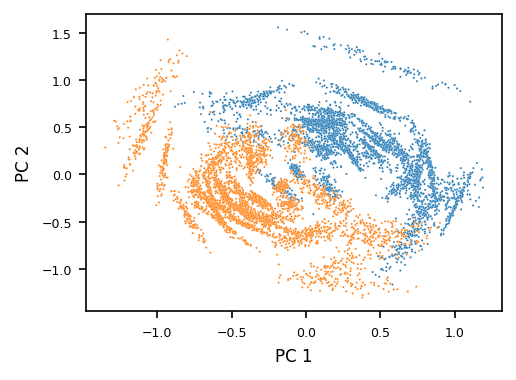

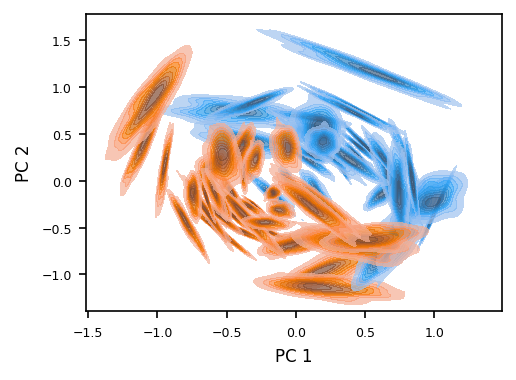

In [17]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8.3*cm, 6*cm), tight_layout = {'pad': 0.1})
fig2, ax2 = plt.subplots(1, 1, figsize=(8.3*cm, 6*cm), tight_layout = {'pad': 0.1})
pcx, pcy = (0, 1)
#sns.scatterplot(x=pca_mean_T[:, 0], y=pca_mean_T[:, 1], s=4, c=[plt.cm.tab10(j) for j in y], ax=ax1)
for j in range(n):
    sns.scatterplot(x=1*T_s[:, j, pcx], y=T_s[:, j, pcy], s=1, c=[plt.cm.tab10(y[j]) for i in range(n_iter)], ax=ax1)#, label=list(d.columns.values)[j], c=['C'+str(labels[j]) for i in range(n_iter)])#, marker=m[labels2[j]], alpha=.5)
    #ax2.scatter(x=T_mcs[:, j, pcx], y=T_mcs[:, j, pcy], s=5)
    sns.kdeplot(x=1*T_s[:, j, pcx], y=T_s[:, j, pcy], shade=True, ax=ax2, color=plt.cm.tab10(y[j]), alpha=0.7)
    #ax2.set_title('kde VIPurPCA')
ax1.set_ylabel('PC 2')
ax1.set_xlabel('PC 1')
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')
#ax1.set_ylim(-10, 10)
fig1.tight_layout()
fig2.tight_layout()
#fig1.savefig('../results/simulation/simulationoverlayview.pdf')
#fig2.savefig('../results/simulation/simulationkde.pdf')

In [39]:
n_samples = 10
S = equipotential_standard_normal(V.shape[0], n_samples+1)
L, lower = jax.scipy.linalg.cho_factor(C+1e-3*np.eye(V.shape[0]), lower=True)
#M_flat, M_unflattener = flatten_util.ravel_pytree(M)
eigv_samples = np.transpose(np.dot(L, S))+V
samples_reshaped = vmap(lambda s: np.transpose(np.reshape(s, (min(n, p_keep), p), 'C')))(eigv_samples)
samples = np.array([X @ i for i in samples_reshaped])

/home/zabel/vipurpca/src/utils.py:87: RuntimeWarning: invalid value encountered in true_divide
  M = np.dot(mu, np.expand_dims(np.cos(theta), axis=0)) + E * np.sin(theta) / theta


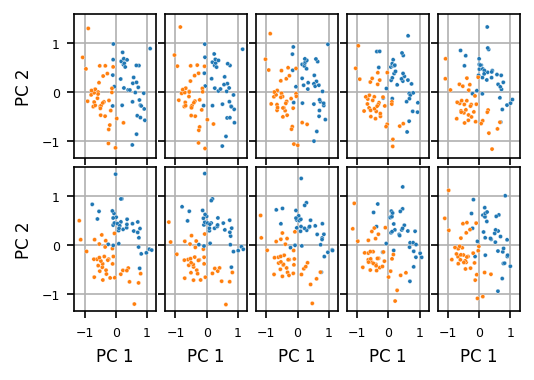

In [42]:
fig, axes = plt.subplots(2, 5, figsize=(8.6*cm, 6*cm), sharex=True, sharey=True, tight_layout = {'pad': 0.1})
ax_list = axes.ravel()
for ax in ax_list:
    ax.set_axisbelow(True)
    ax.grid(True)
for j, sample in enumerate(samples):
    #DecisionBoundaryDisplay.from_estimator(
    #        svms[j], samples[j], response_method="predict",
    #    cmap=plt.cm.coolwarm, alpha=0.8, ax=ax_list[j], eps=1
    #    )
    sns.scatterplot(x=sample[:, 0], y=sample[:, 1], s=4, c=[plt.cm.tab10(j) for j in y], ax=ax_list[j]) 
    ax_list[j].set_xlabel('PC 1')
    ax_list[j].set_ylabel('PC 2')
for ax in ax_list:
    ax.label_outer()
plt.tight_layout()
plt.savefig('../results/mice/micesmallmultiples.pdf')

-1.3457502 1.5975487


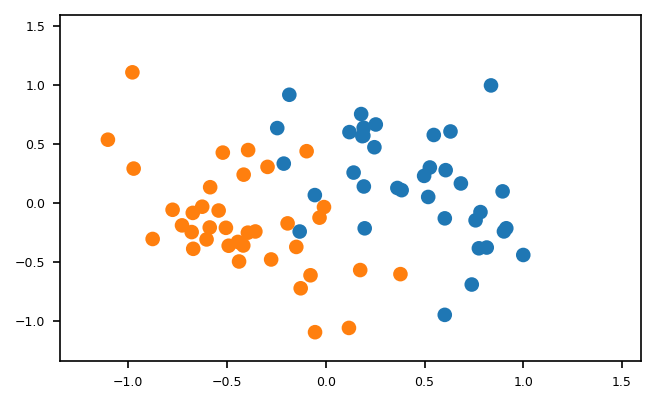

In [43]:
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
fig, ax = plt.subplots(figsize=(5, 3))
sample_0 = samples[0]
labels=y
#sample_0 = sample_0.reshape((len(labels), 2))
minimum = np.min(samples)+0.1*np.min(samples)
maximum = np.max(samples)+0.1*np.max(samples)
print(minimum, maximum)
scat = ax.scatter(sample_0[:, 0], sample_0[:, 1], c=[plt.cm.tab10(j) for j in y])#, cmap='tab10')
ax.set_xlim((minimum, maximum))
ax.set_ylim((minimum, maximum))
#scat, = ax.plot([], [], 'o')
def init():
    #scat.set_data([], [])
    #plt.scatter(mean[:, 0], mean[:, 1], c='black')
    return scat,

def animate(i):
    sample_i = samples[i]
    #sample_i = sample_i.reshape((len(labels), 2))
    #scat.set_data(sample_i[:, 0], sample_i[:, 1])
    scat.set_offsets(sample_i)
    return scat, 

anim = FuncAnimation(
    fig, animate, interval=1000, frames=n_samples, blit=True, init_func=init)

anim.save("../results/mice/miceanimation.gif", dpi=150, writer=PillowWriter(fps=5))

In [220]:
def pca(X_flat, n, p, p_keep):
    X = np.reshape(X_flat, (n, p), 'C')
    _, _, V = np.linalg.svd(X, full_matrices=False)
    return flatten_util.ravel_pytree(V[0:p_keep, :])[0]
f = lambda X: pca(X, n, p, p_keep)
J = jacrev(f)(np.ravel(X_unflattener(X_flat), 'C'))
C_jacrev = J @ (C_in) @ J.T

<AxesSubplot:>

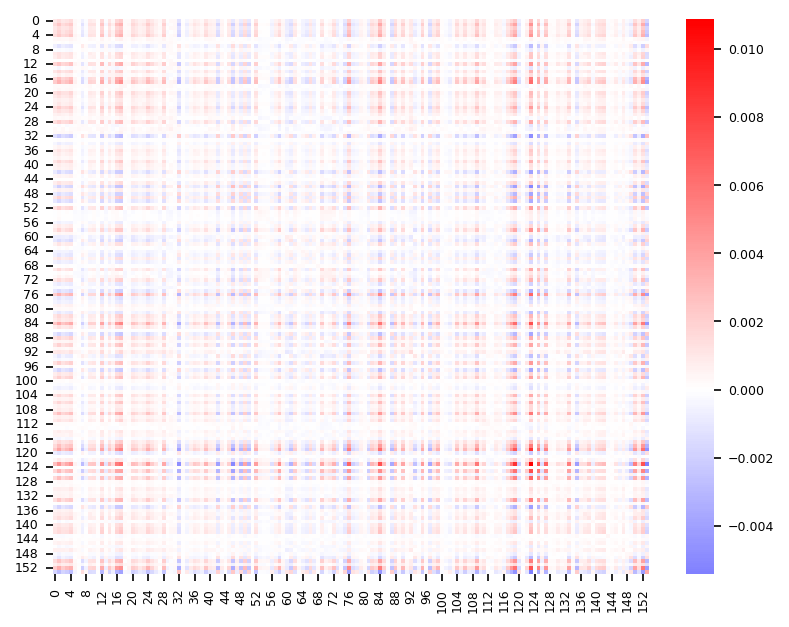

In [221]:
plot_heatmap(C_jacrev)

<AxesSubplot:>

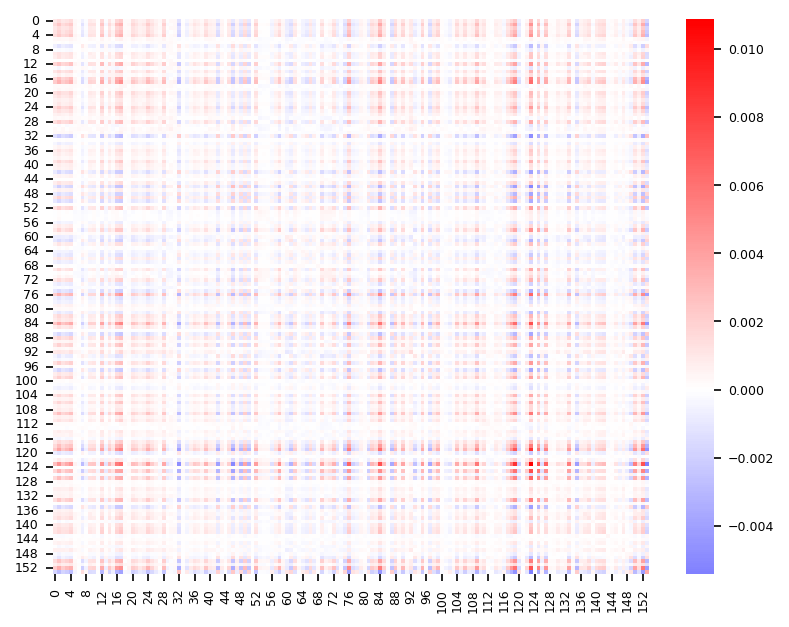

In [219]:
plot_heatmap(C)